#imports

In [57]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


#Imbalanced Data

#generate data

In [5]:
labels = ['pedestrian', 'regular']
img_size = 128

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
data = get_data('/content/drive/My Drive/machine learning/data')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


#split to train and test

In [7]:
train,test = train_test_split(data, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(1605, 2)
(792, 2)


#show the balance in the train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


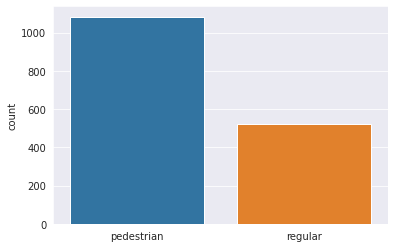

In [8]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("pedestrian")
    else:
        l.append("regular")
sns.set_style('darkgrid')
sns.countplot(l)

#show the balance in the test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


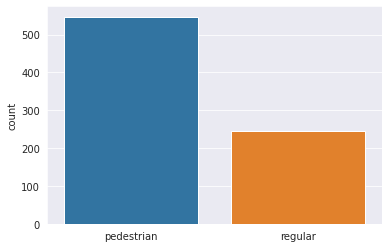

In [9]:
r = []
for i in test:
    if(i[1] == 0):
        r.append("pedestrian")
    else:
        r.append("regular")
sns.set_style('darkgrid')
sns.countplot(r)

#dislpay some images from the data

Text(0.5, 1.0, 'pedestrian')

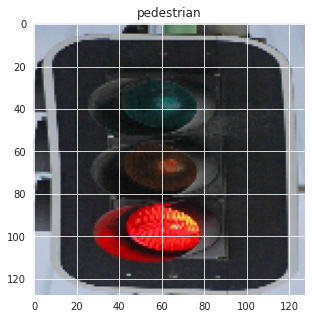

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'pedestrian')

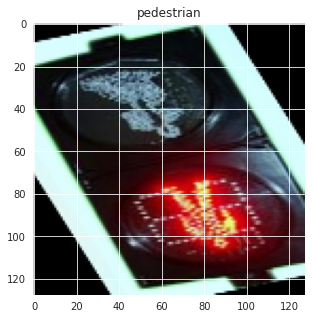

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

#preper the data

In [12]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1605, 128, 128, 3)
(1605,)
(792, 128, 128, 3)
(792,)


#do some random things on the data for better results

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

#CNN model

In [15]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0

In [16]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
epochs = 15
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_test, y_test))

Epoch 1/15
51/51 [==============================] - 40s 789ms/step - loss: 0.1134 - accuracy: 0.9620 - val_loss: 0.0815 - val_accuracy: 0.9760
Epoch 2/15
51/51 [==============================] - 41s 796ms/step - loss: 0.0971 - accuracy: 0.9670 - val_loss: 0.0659 - val_accuracy: 0.9823
Epoch 3/15
51/51 [==============================] - 40s 784ms/step - loss: 0.0704 - accuracy: 0.9769 - val_loss: 0.0482 - val_accuracy: 0.9886
Epoch 4/15
51/51 [==============================] - 40s 784ms/step - loss: 0.0508 - accuracy: 0.9869 - val_loss: 0.0427 - val_accuracy: 0.9874
Epoch 5/15
51/51 [==============================] - 41s 805ms/step - loss: 0.0438 - accuracy: 0.9850 - val_loss: 0.0331 - val_accuracy: 0.9937
Epoch 6/15
51/51 [==============================] - 39s 775ms/step - loss: 0.0377 - accuracy: 0.9919 - val_loss: 0.0295 - val_accuracy: 0.9924
Epoch 7/15
51/51 [==============================] - 41s 796ms/step - loss: 0.0290 - accuracy: 0.9938 - val_loss: 0.0232 - val_accuracy: 0.9962

#show results of CNN

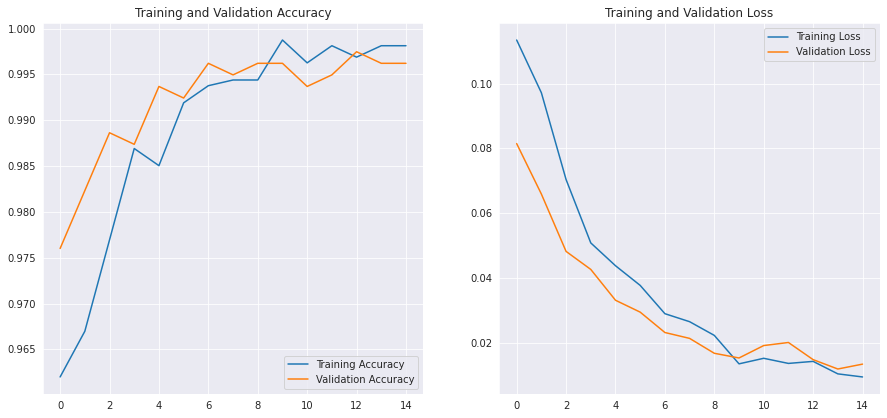

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['pedestrain (Class 0)','regular (Class 1)']))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                      precision    recall  f1-score   support

pedestrain (Class 0)       1.00      1.00      1.00       547
   regular (Class 1)       0.99      1.00      0.99       245

            accuracy                           1.00       792
           macro avg       1.00      1.00      1.00       792
        weighted avg       1.00      1.00      1.00       792



#KNN model

In [21]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]*x_train.shape[3])
x_train.shape

(1605, 49152)

In [22]:
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]*x_test.shape[3])
x_test.shape

(792, 49152)

In [23]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(x_train,y_train)
knn_2 = KNeighborsClassifier(n_neighbors=2)
knn_2.fit(x_train,y_train)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(x_train,y_train)
knn_4 = KNeighborsClassifier(n_neighbors=4)
knn_4.fit(x_train,y_train)
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(x_train,y_train)
# knn_9 = KNeighborsClassifier(n_neighbors=9)
# knn_9.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#show results of KNN

In [24]:
score1 = knn_1.score(x_test, y_test)
score2 = knn_2.score(x_test, y_test)
score3 = knn_3.score(x_test, y_test)
score4 = knn_4.score(x_test, y_test)
score5 = knn_5.score(x_test, y_test)
print("1 neighbour: " ,score1)
print("2 neighbours: " ,score2)
print("3 neighbours: " ,score3)
print("4 neighbours: " ,score4)
print("5 neighbours: " ,score5)

1 neighbour:  0.9785353535353535
2 neighbours:  0.9406565656565656
3 neighbours:  0.946969696969697
4 neighbours:  0.9154040404040404
5 neighbours:  0.9356060606060606


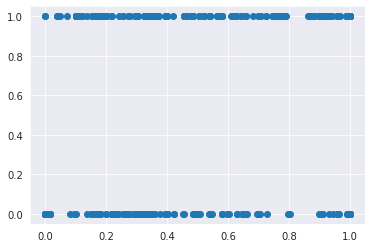

In [25]:
plt.scatter(x_test[:,1],knn_1.predict_proba(x_test)[:,1])

#Logistic regression Model

In [26]:
logisticRegr = LogisticRegression()
result = logisticRegr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#show results of Logistic Regression

In [27]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.9873737373737373


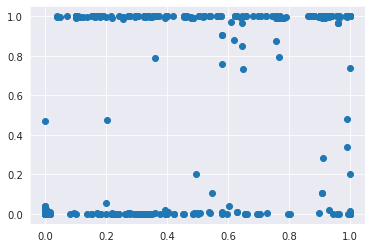

In [28]:
plt.scatter(x_test[:,1],logisticRegr.predict_proba(x_test)[:,1])

#SVM model

In [29]:
svm = svm.SVC(kernel='linear',probability=True) # Linear Kernel
svm.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

#show results of SVM

In [30]:
y_pred = svm.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9886363636363636
Precision: 0.9916666666666667
Recall: 0.9714285714285714


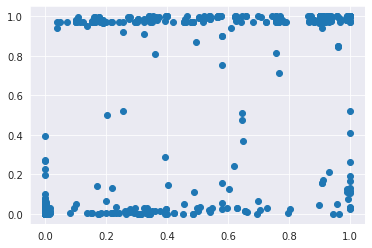

In [31]:
plt.scatter(x_test[:,1],svm.predict_proba(x_test)[:,1])

In [32]:
svm_preds = svm.predict(x_test)
knn_preds = knn_1.predict(x_test)
logistic_preds = logisticRegr.predict(x_test)

#Combine all models to see if it is improving results

In [33]:
# predictions
adaboost_preds = []

for x in range(len(predictions)):
  preds = []
  preds.append(svm_preds[x])
  preds.append(knn_preds[x])
  preds.append(logistic_preds[x])
  preds.append(predictions[x])
  adaboost_preds.append(max(set(preds), key = preds.count))

#results of the combined models

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, adaboost_preds))
print("Precision:",metrics.precision_score(y_test, adaboost_preds))
print("Recall:",metrics.recall_score(y_test, adaboost_preds))

Accuracy: 0.9924242424242424
Precision: 1.0
Recall: 0.9755102040816327


In [35]:
target_names = ['pedestrian', 'regular']
print(classification_report(y_test, adaboost_preds, target_names=target_names))

              precision    recall  f1-score   support

  pedestrian       0.99      1.00      0.99       547
     regular       1.00      0.98      0.99       245

    accuracy                           0.99       792
   macro avg       0.99      0.99      0.99       792
weighted avg       0.99      0.99      0.99       792



In [36]:
print(mean_squared_error(y_test, adaboost_preds, multioutput='raw_values'))

[0.00757576]


In [37]:
print(confusion_matrix(y_test, adaboost_preds))

[[547   0]
 [  6 239]]


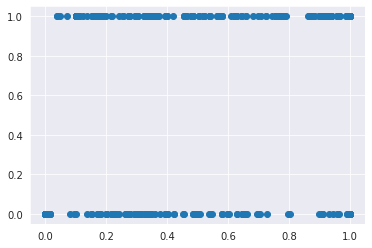

In [38]:
plt.scatter(x_test[:,1],adaboost_preds)

#Balanced Data

#Generate Data

In [39]:
labels = ['pedestrian', 'regular']
img_size = 128

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [40]:
data = get_data('/content/drive/My Drive/machine learning/balanced data')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


#Split to train and test

In [41]:
train,test = train_test_split(data, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(1027, 2)
(507, 2)


#Show the balance in the train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


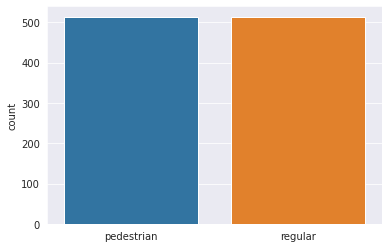

In [42]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("pedestrian")
    else:
        l.append("regular")
sns.set_style('darkgrid')
sns.countplot(l)

#Show the balance in the test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


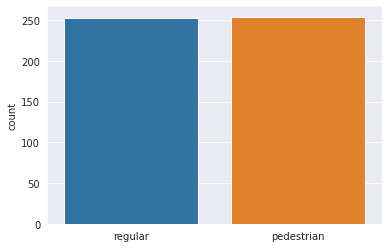

In [43]:
r = []
for i in test:
    if(i[1] == 0):
        r.append("pedestrian")
    else:
        r.append("regular")
sns.set_style('darkgrid')
sns.countplot(r)

#Dislpay some images from the data

Text(0.5, 1.0, 'regular')

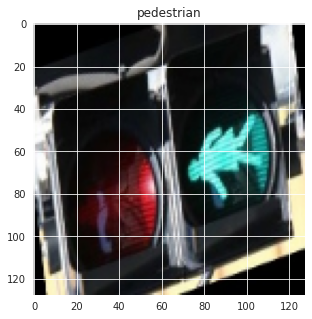

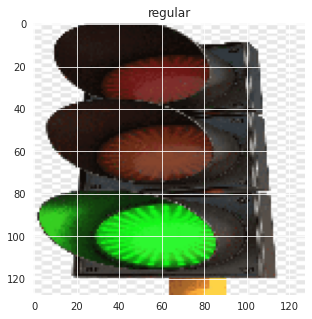

In [44]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

#Preper the data

In [45]:
x_train_list = []
y_train = []
x_test_list = []
y_test = []

for feature, label in train:
  x_train_list.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test_list.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train_list)/255
x_test = np.array(x_test_list)/255
# img = Image.fromarray(x_train[4])
# img.save('my.png')
# img.show()
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1027, 128, 128, 3)
(1027,)
(507, 128, 128, 3)
(507,)


#Do some random things on the data for better results

In [46]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

#CNN model

In [47]:
class CNN:

    def __init__(self, x_train, y_train, x_test, y_test, img_size):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.img_size = img_size
        self.model = self.model()

    def model(self):
        model = Sequential()
        model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(self.img_size, self.img_size, 3)))
        model.add(MaxPool2D())

        model.add(Conv2D(32, 3, padding="same", activation="relu"))
        model.add(MaxPool2D())

        model.add(Conv2D(64, 3, padding="same", activation="relu"))
        model.add(MaxPool2D())
        model.add(Dropout(0.6))

        model.add(Flatten())
        model.add(Dense(128, activation="relu"))
        model.add(Dense(2, activation="softmax"))

        model.summary()
        return model

    def run(self):

        opt = Adam(lr=0.0001)
        self.model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

        epochs = 15
        history = self.model.fit(self.x_train, self.y_train, epochs=epochs, validation_data=(self.x_test, self.y_test))

        """#show results of CNN"""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(epochs)

        plt.figure(figsize=(15, 15))
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

        predictions = self.model.predict_classes(x_test)
        predictions = predictions.reshape(1, -1)[0]
        print(classification_report(self.y_test, predictions, target_names=['pedestrain (Class 0)', 'regular (Class 1)']))
        return predictions

#KNN model

In [48]:
class KNN:

    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def run(self):
        knn_1 = KNeighborsClassifier(n_neighbors=1)
        knn_1.fit(self.x_train, self.y_train)
        knn_2 = KNeighborsClassifier(n_neighbors=2)
        knn_2.fit(self.x_train, self.y_train)
        knn_3 = KNeighborsClassifier(n_neighbors=3)
        knn_3.fit(self.x_train, self.y_train)
        knn_4 = KNeighborsClassifier(n_neighbors=4)
        knn_4.fit(self.x_train, self.y_train)
        knn_5 = KNeighborsClassifier(n_neighbors=5)
        knn_5.fit(self.x_train, self.y_train)

        """#show results of KNN"""

        score1 = knn_1.score(self.x_test, self.y_test)
        score2 = knn_2.score(self.x_test, self.y_test)
        score3 = knn_3.score(self.x_test, self.y_test)
        score4 = knn_4.score(self.x_test, self.y_test)
        score5 = knn_5.score(self.x_test, self.y_test)
        print("1 neighbour: ", score1)
        print("2 neighbours: ", score2)
        print("3 neighbours: ", score3)
        print("4 neighbours: ", score4)
        print("5 neighbours: ", score5)

        plt.scatter(self.x_test[:, 1], knn_1.predict_proba(self.x_test)[:, 1])
        return knn_1

#Logistic Regression

In [49]:
class logisticRegression:

    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def run(self):
        logisticRegr = LogisticRegression()
        result = logisticRegr.fit(self.x_train, self.y_train)

        """#show results of Logistic Regression"""

        score = logisticRegr.score(self.x_test, self.y_test)
        print(score)

        plt.scatter(self.x_test[:, 1], logisticRegr.predict_proba(self.x_test)[:, 1])
        return logisticRegr

#SVM model

In [50]:
class SVM:

    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def run(self):
        SVM = svm.SVC(kernel='linear', probability=True)  # Linear Kernel
        SVM.fit(self.x_train, self.y_train)

        """#show results of SVM"""

        y_pred = SVM.predict(self.x_test)
        print("Accuracy:", metrics.accuracy_score(self.y_test, y_pred))
        print("Precision:", metrics.precision_score(self.y_test, y_pred))
        print("Recall:", metrics.recall_score(self.y_test, y_pred))

        plt.scatter(self.x_test[:, 1], SVM.predict_proba(self.x_test)[:, 1])
        return SVM

#Adaboost model (combining all models)

In [51]:
class adaboost:

    def __init__(self, x_test, y_test, cnn, knn, lgr, svm):
        self.x_test = x_test
        self.y_test = y_test
        self.cnn = cnn
        self.knn = knn
        self.lgr = lgr
        self.svm = svm

    def run(self):
        cnn_preds = self.cnn
        cnn_acc = metrics.accuracy_score(self.y_test, cnn_preds)
        svm_preds = self.svm.predict(self.x_test)
        svm_acc = metrics.accuracy_score(self.y_test, svm_preds)
        knn_preds = self.knn.predict(self.x_test)
        knn_acc = metrics.accuracy_score(self.y_test, knn_preds)
        logistic_preds = self.lgr.predict(self.x_test)
        logistic_acc = metrics.accuracy_score(self.y_test, logistic_preds)

        # predictions
        adaboost_preds = []

        for x in range(len(self.cnn)):
            preds = 0.
            if svm_preds[x] == 0:
                preds += svm_acc * -1
            else:
                preds += svm_acc * 1
            if knn_preds[x] == 0:
                preds += knn_acc * -1
            else:
                preds += knn_acc * 1
            if logistic_preds[x] == 0:
                preds += logistic_acc * -1
            else:
                preds += logistic_acc * 1
            if cnn_preds[x] == 0:
                preds += cnn_acc * -1
            else:
                preds += cnn_acc *1
            if preds >= 0:
                adaboost_preds.append(1)
            else:
                adaboost_preds.append(0)


        """#results of the combined models"""

        print("Accuracy:", metrics.accuracy_score(self.y_test, adaboost_preds))
        print("Precision:", metrics.precision_score(self.y_test, adaboost_preds))
        print("Recall:", metrics.recall_score(self.y_test, adaboost_preds))

        target_names = ['pedestrian', 'regular']
        print(classification_report(self.y_test, adaboost_preds, target_names=target_names))

        print(mean_squared_error(self.y_test, adaboost_preds, multioutput='raw_values'))

        print(confusion_matrix(self.y_test, adaboost_preds))

        plt.scatter(x_test[:, 1], adaboost_preds)

#Find Errors

In [52]:
def findErrors(x_test, y_test, algo,isCnn= False):
    lst = []
    if(isCnn):
        for idx, prediction, label in zip(enumerate(x_test), algo, y_test):
            if prediction != label:
                lst.append(idx[0])
    else:
        for idx, prediction, label in zip(enumerate(x_test), algo.predict(x_test), y_test):
            if prediction != label:
                lst.append(idx[0])
    # npArr = np.array(lst, dtype=int)
    print("list: ", lst)
    return np.array(lst, dtype=int)
    # np.save = ('svm.npy', npArr)

#Run models

#CNN Results


 CNN 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


33/33 [==============================] - 26s 762ms/step - loss: 0.6447 - accuracy: 0.6136 - val_loss: 0.4559 - val_accuracy: 0.8047
Epoch 2/15
33/33 [==============================] - 25s 762ms/step - loss: 0.4132 - accuracy: 0.8057 - val_loss: 0.2872 - val_accuracy: 0.8876
Epoch 3/15
33/33 [==============================] - 25s 759ms/step - loss: 0.2323 - accuracy: 0.9364 - val_loss: 0.3566 - val_accuracy: 0.8146
Epoch 4/15
33/33 [==============================] - 25s 756ms/step - loss: 0.2655 - accuracy: 0.8803 - val_loss: 0.1607 - val_accuracy: 0.9566
Epoch 5/15
33/33 [==============================] - 25s 761ms/step - loss: 0.1205 - accuracy: 0.9659 - val_loss: 0.1321 - val_accuracy: 0.9586
Epoch 6/15
33/33 [==============================] - 25s 745ms/step - loss: 0.1221 - accuracy: 0.9529 - val_loss: 0.1168 - val_accuracy: 0.9665
Epoch 7/15
33/33 [==============================] - 24s 744ms/step - loss: 0.0890 - accuracy: 0.9772 - val_loss: 0.1029 - val_accuracy: 0.9704
Epoch 8/15

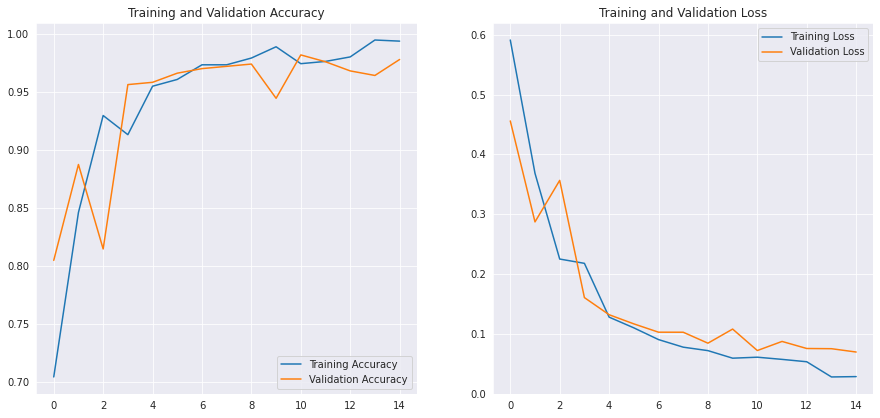

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                      precision    recall  f1-score   support

pedestrain (Class 0)       0.97      0.99      0.98       254
   regular (Class 1)       0.99      0.96      0.98       253

            accuracy                           0.98       507
           macro avg       0.98      0.98      0.98       507
        weighted avg       0.98      0.98      0.98       507



In [53]:
img_size = 128

print("\n CNN \n")
CNN = CNN(x_train, y_train, x_test, y_test, img_size).run()

#KNN Results


 KNN 

1 neighbour:  0.9684418145956607
2 neighbours:  0.9250493096646942
3 neighbours:  0.9349112426035503
4 neighbours:  0.903353057199211
5 neighbours:  0.9230769230769231


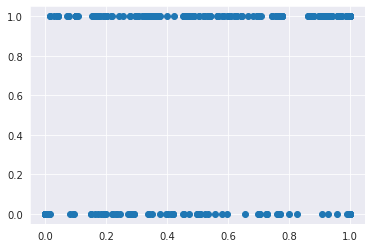

In [54]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

print("\n KNN \n")
KNN = KNN(x_train, y_train, x_test, y_test).run()

#Logistic Regression Results


 Logistic Regression 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9664694280078896


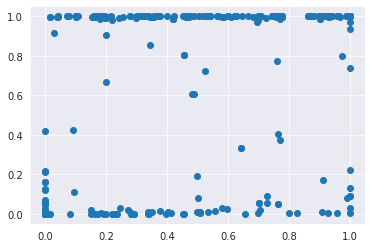

In [55]:
print("\n Logistic Regression \n")
LGR = logisticRegression(x_train, y_train, x_test, y_test).run()

#SVM Results


 SVM 

Accuracy: 0.9644970414201184
Precision: 0.9757085020242915
Recall: 0.9525691699604744


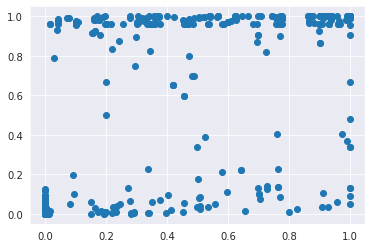

In [58]:
print("\n SVM \n")
SVM = SVM(x_train, y_train, x_test, y_test).run()

#Adaboost Results


 Adaboost 

Accuracy: 0.980276134122288
Precision: 0.9879518072289156
Recall: 0.9723320158102767
              precision    recall  f1-score   support

  pedestrian       0.97      0.99      0.98       254
     regular       0.99      0.97      0.98       253

    accuracy                           0.98       507
   macro avg       0.98      0.98      0.98       507
weighted avg       0.98      0.98      0.98       507

[0.01972387]
[[251   3]
 [  7 246]]


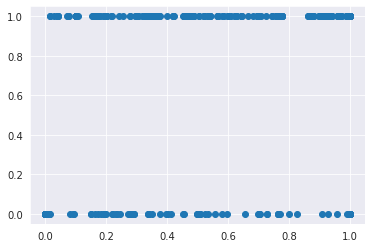

In [59]:
print("\n Adaboost \n")
adb = adaboost(x_test, y_test, CNN, KNN, LGR, SVM)
adb.run()

In [75]:
new_data = get_data('/content/drive/My Drive/machine learning/new_data')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [85]:
x = []
y = []

for feature, label in new_data:
  x.append(feature)
  y.append(label)

# Normalize the data
x = np.array(x) / 255

x.reshape(-1, img_size, img_size, 1)
y = np.array(y)

In [87]:
cnn_preds = model.predict_classes(x)
cnn_acc = metrics.accuracy_score(y, cnn_preds)
print(cnn_preds)
print(cnn_acc)

[1 1 0 0 0 1 0 1 1 0]
0.6


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [94]:
x_ = x.reshape(x.shape[0],x.shape[1]*x.shape[2]*x.shape[3])
x_.shape

(10, 49152)

In [95]:
svm_preds = SVM.predict(x_)
svm_acc = metrics.accuracy_score(y, svm_preds)
knn_preds = KNN.predict(x_)
knn_acc = metrics.accuracy_score(y, knn_preds)
logistic_preds = LGR.predict(x_)
logistic_acc = metrics.accuracy_score(y, logistic_preds)


In [96]:
print("SVM" , svm_acc)
print("KNN" ,knn_acc)
print("Logistic Regression" ,logistic_acc)

SVM 0.8
KNN 0.6
Logistic Regression 0.6


Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
              precision    recall  f1-score   support

  pedestrian       0.75      0.60      0.67         5
     regular       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

[0.3]
[[3 2]
 [1 4]]


ValueError: ignored

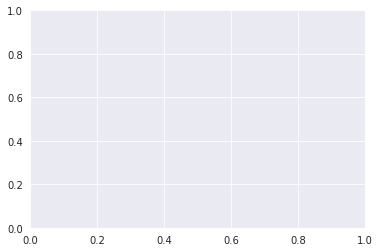

In [97]:
adb = adaboost(x_, y, cnn_preds, KNN, LGR, SVM)
adb.run()